Engineering Features and Preparing Data to Use in Modeling
Objective

Now that you understand your data, your next step is to engineer features and prepare two sets of data to use for modeling: one that contains only numeric values, and one that contains numeric and categorical values, so you can leverage the advantage of H2O Random Forests over scikit-learn Random Forests.
Workflow

Load your data from Milestone 1, and make sure it looks OK.

Engineer and clean features from your string and datetime columns and examine their relationship to the target column “LOAN_DEFAULT.”

Parse a few columns that have date spans and are strings (e.g., AVERAGE_ACCT_AGE_MONTHS) for the appropriate data type (e.g., integer, datetime) using string methods or regex (the re library).
Examine the relationship of new features to the target using appropriate methods such as Pearson correlation or mutual information.
Create a copy of the DataFrame for use in scikit-learn to one-hot-encode (OHE) categorical columns and convert all columns to numeric types.

Perform any missing value imputation .
Take care to simplify the data if necessary. For example, if more than 50% of the data can be represented with 3 categories, you might group all your other data into an ”other” category to simplify it.
If unique values in a column/feature are too spread out (e.g., each unique value is less than 1% of the total), it won’t work well for OHE. But if some unique values in the column make up ~5% of the total, you can use the risk ratio to evaluate if that column might be useful.
Save the OHE and H2O DataFrames to disk (e.g., as CSV files) for your next step; also save about 10% or less of down-sampled versions of the data for developing your solution to Milestone 3.

If you find the .apply() method in pandas is slow, you can parallelize it using swifter.

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import pathlib
import h2o


In [2]:
df = pd.read_csv('loan_data_cleaned.csv')
df.head().T

,0,1,2,3,4
uniqueid,587200,479470,448682,534325,469385
disbursed_amount,65607,55259,50503,63513,42794
asset_cost,78500,63439,66456,72500,60321
ltv,85,89.85,78.55,88.69,72.94
employment_type,Self employed,Salaried,Salaried,Salaried,Self employed
sec_current_balance,108425,0,0,0,0
pri_disbursed_amount,7028184,1874823,0,85939,0
primary_instal_amt,4839,0,0,0,0
sec_instal_amt,0,0,0,0,0
perform_cns_score,585,741,0,691,0


In [3]:
employ_df = pd.get_dummies(df['employment_type'])
employ_df.columns = [col.lower().replace(' ', '_') for col in employ_df.columns]
df = pd.merge(df, employ_df, left_index=True, right_index=True)
del df['employment_type']

# Impute missing values

Should some of these values be normalized at all??? I'm unclear.

<AxesSubplot:>

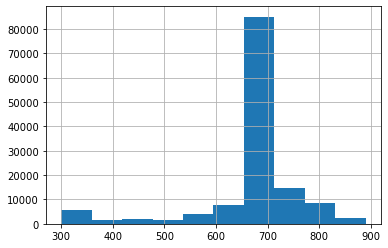

In [4]:
# Treat 0s As missing as a separate variable, not sure if these should be imputed
df[df['perform_cns_score'] != 0]['perform_cns_score'].median()
df['perform_cns_score_cat'] = df['perform_cns_score']
df['missing_cns_score'] = df['perform_cns_score'] == 0
df.loc[
    df['missing_cns_score'] == 1,
    'perform_cns_score'
] = df[df['perform_cns_score'] != 0]['perform_cns_score'].median()
df['perform_cns_score'].hist()

In [13]:
# profile = ProfileReport(df, explorative=True)
# profile.to_file('loan_data.html')

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

D:\prog\Anaconda3\envs\manning_rf\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlations

In [5]:
df.corrwith(df['loan_default'])

uniqueid                      0.029357
disbursed_amount              0.082687
asset_cost                    0.035267
ltv                           0.075647
sec_current_balance          -0.005351
pri_disbursed_amount         -0.013943
primary_instal_amt           -0.012018
sec_instal_amt               -0.004786
perform_cns_score            -0.165078
loan_default                  1.000000
age_at_disbursal             -0.011580
credit_history_in_months     -0.085651
average_acct_age_in_months   -0.081873
salaried                     -0.237717
self_employed                 0.242872
perform_cns_score_cat        -0.261489
missing_cns_score             0.205408
dtype: float64

In [6]:
# correlations too low
del df['sec_instal_amt']
del df['sec_current_balance']

# Sample Data

In [7]:
development_df, validation_df = train_test_split(
    df,
    train_size=0.25,
    stratify=df['loan_default'],
    random_state=42
)
training_df, hyperparameter_df = train_test_split(
    development_df,
    train_size=0.05,
    stratify=development_df['loan_default'],
    random_state=42
)



# Output as Dataframe and H2O

In [8]:
datadir = pathlib.Path('data')
datadir.mkdir(exist_ok=True)


In [10]:
training_df.drop(columns='perform_cns_score_cat').to_csv(datadir / 'training.ohe.csv', index=False)
hyperparameter_df.drop(columns='perform_cns_score_cat').to_csv(datadir / 'hyperparameter.ohe.csv', index=False)
validation_df.drop(columns='perform_cns_score_cat').to_csv(datadir / 'validation.ohe.csv', index=False)


In [11]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu11.41+23-CA (build 11.0.8+10-LTS, mixed mode)
  Starting server from D:\prog\Anaconda3\envs\manning_rf\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\dcron\AppData\Local\Temp\tmpnhzxkm9w
  JVM stdout: C:\Users\dcron\AppData\Local\Temp\tmpnhzxkm9w\h2o_dcron_started_from_python.out
  JVM stderr: C:\Users\dcron\AppData\Local\Temp\tmpnhzxkm9w\h2o_dcron_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,4 months and 17 days !!!
H2O_cluster_name:,H2O_from_python_dcron_0j46vn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.988 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [13]:
h2o.export_file(h2o.H2OFrame(training_df), str(datadir / 'training.h2o'))
h2o.export_file(h2o.H2OFrame(hyperparameter_df), str(datadir / 'hyperparameter.h2o'))
h2o.export_file(h2o.H2OFrame(validation_df), str(datadir / 'validation.h2o'))


Parse progress: |█████████████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%


In [14]:
h2o.shutdown()



<ipython-input-14-0cd96ac36c4f>:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


H2O session _sid_b723 closed.
